# 📗 Notebook 2: Product Quantization (PQ)

## What is Quantization?

In the previous notebook, we saw how **IVF indexing** speeds up search by organizing vectors into clusters. But we still store every vector in **full float32 precision** — that's **512 bytes per vector** for 128 dimensions.

At scale, **memory becomes the bottleneck**:

| Vectors | Raw Storage (128D, float32) |
|---------|---------------------------|
| 1 Million | 488 MB |
| 10 Million | 4.8 GB |
| 100 Million | 48 GB |
| 1 Billion | 477 GB ❌ |

**Quantization** compresses vectors so they use far less memory, with only a small loss in accuracy.

---

## What is Product Quantization (PQ)?

PQ is the most popular vector compression technique. It works by:

1. **Split** each vector into smaller sub-vectors
2. **Train** a codebook for each sub-vector position (like a dictionary)
3. **Replace** each sub-vector with its closest codebook entry's **ID** (a single byte)

```
Original vector (128 dimensions, 512 bytes):
┌─────────┬─────────┬─────────┬──── ─ ─ ──┬─────────┐
│ dim 1-8 │ dim 9-16│dim 17-24│   . . .   │dim121-128│   ← 16 sub-vectors
│ 8 floats│ 8 floats│ 8 floats│           │ 8 floats │   ← 32 bytes each
└────┬────┴────┬────┴────┬────┴──── ─ ─ ──┴────┬────┘
     ↓         ↓         ↓                      ↓
┌────────┐┌────────┐┌────────┐            ┌────────┐
│code: 42││code: 7 ││code:198│   . . .    │code: 55│   ← look up in codebook
│ 1 byte ││ 1 byte ││ 1 byte │            │ 1 byte │
└────────┘└────────┘└────────┘            └────────┘

Compressed vector: [42, 7, 198, ..., 55]  →  16 bytes total!

Compression: 512 bytes → 16 bytes = 32× smaller! 🎉
```

> **Analogy:** Imagine describing a person's face. Instead of exact measurements (nose width = 3.247cm), you say "nose type #7" from a catalog of 256 nose types. Less precise, but you can describe a face in a few codes! 🧑‍🎨

---

Let's see this in action!

## 🛠 Setup & Data Generation

Same setup as Notebook 1 — 200,000 clustered vectors in 128 dimensions.

In [17]:
import lancedb
import numpy as np
import pandas as pd
import pyarrow as pa
import matplotlib.pyplot as plt
import time
import shutil
import os
import warnings
warnings.filterwarnings('ignore')

print(f"LanceDB version: {lancedb.__version__}")

LanceDB version: 0.27.1


In [18]:
# ── Configuration (same as Notebook 1) ────────────────────────
NUM_VECTORS = 200_000
DIMENSION   = 128
TOP_K       = 10
NUM_QUERIES = 50
DB_PATH     = "./demo_lancedb_pq"
SEED        = 42

np.random.seed(SEED)
print(f"⚙️ Config: {NUM_VECTORS:,} vectors × {DIMENSION}D")

⚙️ Config: 200,000 vectors × 128D


In [19]:
# ── Generate Clustered Data ─────────────────────────────────────
# We generate vectors in clusters to simulate real-world data distributions.
NUM_CLUSTERS = 50
vectors_per_cluster = NUM_VECTORS // NUM_CLUSTERS
centers = np.random.randn(NUM_CLUSTERS, DIMENSION).astype(np.float32) * 5

all_vectors = []
for center in centers:
    cluster_vecs = center + np.random.randn(vectors_per_cluster, DIMENSION).astype(np.float32) * 0.5
    all_vectors.append(cluster_vecs)

vectors = np.vstack(all_vectors)
np.random.shuffle(vectors)

# Query vectors (near cluster centers)
query_vectors = np.array([
    centers[np.random.randint(NUM_CLUSTERS)] + np.random.randn(DIMENSION).astype(np.float32) * 0.5
    for _ in range(NUM_QUERIES)
])

print(f"✨ Generated {vectors.shape[0]:,} vectors and {NUM_QUERIES} queries.")
print(f"📦 Raw data memory footprint: {vectors.nbytes / 1024**2:.1f} MB")

✨ Generated 200,000 vectors and 50 queries.
📦 Raw data memory footprint: 97.7 MB


In [20]:
# ── Load into LanceDB ─────────────────────────────────────────
if os.path.exists(DB_PATH):
    shutil.rmtree(DB_PATH)

db = lancedb.connect(DB_PATH)
data = pa.table({
    "id":     pa.array(range(NUM_VECTORS), type=pa.int64()),
    "vector": pa.FixedSizeListArray.from_arrays(
                  pa.array(vectors.flatten(), type=pa.float32()),
                  list_size=DIMENSION
              )
})
tbl = db.create_table("vectors", data)
print(f"✅ LanceDB table created: {tbl.count_rows():,} rows")

✅ LanceDB table created: 200,000 rows


---
## 🧰 Helper Functions

| Function | What it does |
|----------|-------------|
| `brute_force_knn()` | Exact KNN via NumPy — the ground truth baseline |
| `compute_ground_truth()` | Precomputes exact neighbors for all queries |
| `recall_at_k()` | Measures accuracy: fraction of true neighbors found |
| `benchmark_search()` | Runs LanceDB searches and measures time + recall |

### 🎓 Student Notes: Concept Check

#### 1. What is Ground Truth?
Think of **Ground Truth** as the 'Answer Key.' We compute the nearest neighbors by comparing our query to **every single vector** in the database. It is 100% accurate but very slow. We use it as a baseline to measure how well our fast (quantized) search performs.

#### 2. Why do we need `benchmark_search`?
In vector databases, there is always a trade-off between **Speed** and **Accuracy**. We need a standardized way to run multiple queries and report back the average latency and accuracy. This helper function allows us to experiment with different settings and see the impact immediately.

In [5]:
def brute_force_knn(vectors, query, k):
    """Exact KNN — compute distance to ALL vectors and return top-k indices."""
    dists = np.sum((vectors - query) ** 2, axis=1)
    top_k_idx = np.argpartition(dists, k)[:k]
    top_k_idx = top_k_idx[np.argsort(dists[top_k_idx])]
    return set(top_k_idx)

def compute_ground_truth(vectors, query_vectors, k):
    """Compute exact nearest neighbors for all queries to use as a baseline."""
    return [brute_force_knn(vectors, q, k) for q in query_vectors]

def recall_at_k(retrieved_ids, ground_truth_ids):
    """Calculate Search Accuracy (Recall): What % of 'Ground Truth' answers did we find?"""
    if not ground_truth_ids: return 0.0
    return len(retrieved_ids & ground_truth_ids) / len(ground_truth_ids)

In [6]:
def benchmark_search(table, query_vectors, ground_truth, k, nprobes=None,
                     refine_factor=None, use_index=True):
    """Benchmark search performance and accuracy across all queries."""
    times, recalls = [], []
    for i, q in enumerate(query_vectors):
        qb = table.search(q.tolist()).limit(k).metric("L2")
        
        if not use_index:
            qb = qb.bypass_vector_index()
        if nprobes is not None:
            qb = qb.nprobes(nprobes)
        if refine_factor is not None:
            qb = qb.refine_factor(refine_factor)
            
        start = time.perf_counter()
        results = qb.to_pandas()
        elapsed = time.perf_counter() - start
        
        times.append(elapsed)
        recalls.append(recall_at_k(set(results["id"].tolist()), ground_truth[i]))
        
    return {
        "avg_time_ms": np.mean(times) * 1000,
        "p95_time_ms": np.percentile(times, 95) * 1000,
        "avg_recall":  np.mean(recalls),
        "min_recall":  np.min(recalls),
    }

In [7]:
# ── Compute Ground Truth ────────────────────────────────────────
print("⏳ Computing ground truth (exact neighbors) for all queries...")
ground_truth = compute_ground_truth(vectors, query_vectors, TOP_K)
print(f"✅ Computed ground truth for {len(query_vectors)} queries.")

⏳ Computing ground truth (exact neighbors) for all queries...
✅ Computed ground truth for 50 queries.


In [8]:
# ── Brute Force Baseline ───────────────────────────────────────
print("🔍 Running brute-force baseline search (No Index)...")
bf_results = benchmark_search(tbl, query_vectors, ground_truth, TOP_K, use_index=False)
print(f"   ⏱️ Avg Latency: {bf_results['avg_time_ms']:.2f} ms")
print(f"   🎯 Search Accuracy:  {bf_results['avg_recall']:.4f}")

🔍 Running brute-force baseline search (No Index)...
   ⏱️ Avg Latency: 15.50 ms
   🎯 Avg Recall:  1.0000


---
## 🗜️ Building an IVF_PQ Index

Now let's build an index that combines **IVF** (partitioning) with **Product Quantization** (compression).

### Key Parameters

| Parameter | Our Value | What it controls |
|-----------|-----------|------------------|
| `num_partitions` | 64 | How many IVF clusters to create |
| `num_sub_vectors` | 16 | How many pieces to split each vector into |
| `num_bits` | 8 | Bits per code (8 bits = 256 codebook entries) |

With `num_sub_vectors=16`, each 128D vector is split into 16 sub-vectors of 8 dimensions each. Each sub-vector is replaced by a 1-byte code → **16 bytes total** instead of 512 bytes.

In [9]:
# ── Build IVF_PQ index ────────────────────────────────────────
NUM_PARTITIONS  = 64
NUM_SUB_VECTORS = 16   # 128D ÷ 16 = 8 dimensions per sub-vector

raw_bytes   = DIMENSION * 4            # 512 bytes (float32)
pq_bytes    = NUM_SUB_VECTORS * 1      # 16 bytes (one code per sub-vector)
compression = raw_bytes / pq_bytes

print(f"🏗️  Building IVF_PQ index...")
print(f"   ├── 🧩 Partitions:    {NUM_PARTITIONS}")
print(f"   ├── 🗜️  Sub-vectors:   {NUM_SUB_VECTORS} ({DIMENSION // NUM_SUB_VECTORS} dims each)")
print(f"   ├── 🔢 Bits per code: 8 (256 codes per sub-vector)")
print(f"   └── 📉 Compression:   {raw_bytes}B → {pq_bytes}B ({compression:.0f}x smaller)\n")

start = time.time()
tbl.create_index(
    metric="L2",
    num_partitions=NUM_PARTITIONS,
    num_sub_vectors=NUM_SUB_VECTORS,
    index_type="IVF_PQ",
    replace=True
)
build_duration = time.time() - start
print(f"✅ IVF_PQ index built successfully in {build_duration:.2f}s")

🏗️  Building IVF_PQ index...
   ├── 🧩 Partitions:    64
   ├── 🗜️  Sub-vectors:   16 (8 dims each)
   ├── 🔢 Bits per code: 8 (256 codes per sub-vector)
   └── 📉 Compression:   512B → 16B (32x smaller)

✅ IVF_PQ index built successfully in 7.05s


### How does PQ affect search accuracy?

Because we've **compressed** the vectors, distances are now **approximate** — computed using codebook entries instead of the original float values. This means:

- Some neighbors might be missed (lower recall)
- Some non-neighbors might appear (false positives)

Let's benchmark and see how much recall we lose:

In [10]:
# ── Benchmark IVF_PQ with varying nprobes ────────────────────
nprobe_values = [1, 2, 5, 10, 20, 50]
pq_results = {}

print(f"📊 Benchmarking IVF_PQ Sensitivity (nprobes)\n")
print(f"{'nprobes':<10} {'Latency (ms)':<18} {'Accuracy:<15} {'Speedup':<15}")
print("─" * 60)

for np_val in nprobe_values:
    result = benchmark_search(tbl, query_vectors, ground_truth, TOP_K, nprobes=np_val)
    pq_results[np_val] = result
    speedup = bf_results['avg_time_ms'] / result['avg_time_ms']
    print(f"{np_val:<10} {result['avg_time_ms']:<18.2f} {result['avg_recall']:<15.4f} {speedup:<15.1f}x")

print(f"\n💡 Recall is lower than IVF_FLAT because of lossy compression.")
print(f"   Trade-off: We save ~{compression:.0f}x storage at the cost of some accuracy.")

📊 Benchmarking IVF_PQ Sensitivity (nprobes)

nprobes    Latency (ms)       Recall@10       Speedup        
────────────────────────────────────────────────────────────
1          1.31               0.1380          11.8           x
2          1.06               0.1400          14.7           x
5          1.02               0.1460          15.1           x
10         1.16               0.1460          13.3           x
20         1.27               0.1460          12.2           x
50         1.52               0.1460          10.2           x

💡 Recall is lower than IVF_FLAT because of lossy compression.
   Trade-off: We save ~32x storage at the cost of some accuracy.


---
## 🔧 Refine Factor: Getting Recall Back

PQ's approximate distances can cause some true neighbors to be ranked too low and dropped. The **refine factor** fixes this:

```
Without refine:    Query → PQ distances → Top 10 → Done (some may be wrong)

With refine=5:     Query → PQ distances → Top 50 (5× more candidates)
                                       → re-rank using ORIGINAL vectors
                                       → Top 10 → Much better! ✅
```

The tradeoff: refine adds a bit of query time (reading original vectors from disk), but significantly improves recall.

> **Analogy:** PQ is like pre-screening job applications by keywords (fast but rough). Refine is like reading the top 50 resumes in detail before picking the final 10. 📄✨

In [11]:
# ── Refine Factor Experiment ──────────────────────────────────
NPROBES_FIXED = 20  # Fix nprobes and vary refine factor

refine_values = [None, 2, 5, 10, 25]
refine_results = {}

print(f"🔧 Refine Factor Sensitivity (nprobes={NPROBES_FIXED} fixed)\n")
print(f"{'Refine Factor':<16} {'Latency (ms)':<18} {'Recall@'+str(TOP_K):<15} {'Gain':<15}")
print("─" * 65)

base_recall = pq_results[NPROBES_FIXED]['avg_recall']

for rf in refine_values:
    result = benchmark_search(tbl, query_vectors, ground_truth, TOP_K,
                              nprobes=NPROBES_FIXED, refine_factor=rf)
    label = str(rf) if rf else "None"
    gain = f"+{(result['avg_recall'] - base_recall)*100:.1f}%" if rf else "baseline"
    refine_results[rf] = result
    print(f"{label:<16} {result['avg_time_ms']:<18.2f} {result['avg_recall']:<15.4f} {gain:<15}")

print(f"\n💡 Refine=5 recovers most recall with moderate time cost.")
print(f"   Refine=25 approaches brute-force accuracy but is significantly slower.")

🔧 Refine Factor Sensitivity (nprobes=20 fixed)

Refine Factor    Latency (ms)       Recall@10       Gain           
─────────────────────────────────────────────────────────────────
None             1.45               0.1460          baseline       
2                1.42               0.2300          +8.4%          
5                1.68               0.3920          +24.6%         
10               1.84               0.5480          +40.2%         
25               2.49               0.7460          +60.0%         

💡 Refine=5 recovers most recall with moderate time cost.
   Refine=25 approaches brute-force accuracy but is significantly slower.


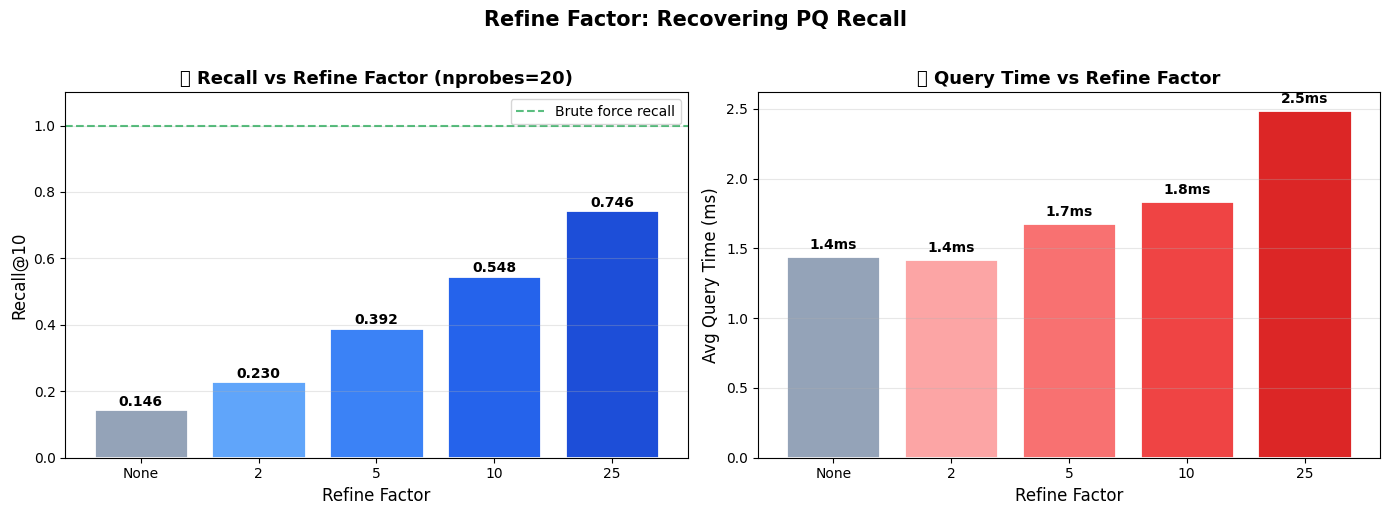

In [12]:
# ── Visualize refine factor impact ────────────────────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

rf_labels  = ['None', '2', '5', '10', '25']
rf_recalls = [refine_results[rf]['avg_recall'] for rf in refine_values]
rf_times   = [refine_results[rf]['avg_time_ms'] for rf in refine_values]

# Recall
bars1 = ax1.bar(rf_labels, rf_recalls, color=['#94a3b8', '#60a5fa', '#3b82f6', '#2563eb', '#1d4ed8'],
               edgecolor='white', linewidth=2)
ax1.axhline(y=bf_results['avg_recall'], color='#16a34a', linestyle='--', alpha=0.7,
            label='Brute force recall')
for bar, r in zip(bars1, rf_recalls):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{r:.3f}', ha='center', fontsize=10, fontweight='bold')
ax1.set_xlabel('Refine Factor', fontsize=12)
ax1.set_ylabel(f'Recall@{TOP_K}', fontsize=12)
ax1.set_title(f'🎯 Recall vs Refine Factor (nprobes={NPROBES_FIXED})', fontsize=13, fontweight='bold')
ax1.set_ylim(0, 1.1)
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# Time
bars2 = ax2.bar(rf_labels, rf_times, color=['#94a3b8', '#fca5a5', '#f87171', '#ef4444', '#dc2626'],
               edgecolor='white', linewidth=2)
for bar, t in zip(bars2, rf_times):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(rf_times)*0.02,
             f'{t:.1f}ms', ha='center', fontsize=10, fontweight='bold')
ax2.set_xlabel('Refine Factor', fontsize=12)
ax2.set_ylabel('Avg Query Time (ms)', fontsize=12)
ax2.set_title(f'⏱ Query Time vs Refine Factor', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.suptitle('Refine Factor: Recovering PQ Recall', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 💾 Storage Savings: The Real Win

PQ's biggest value isn't just speed — it's **dramatically reducing memory and disk usage**. Let's quantify this.

In [13]:
# ── Storage Comparison Analysis ───────────────────────────────
raw_total_mb = (raw_bytes * NUM_VECTORS) / 1024**2
pq_total_mb  = (pq_bytes * NUM_VECTORS) / 1024**2

scales = {
    '200K (this demo)': NUM_VECTORS,
    '1 Million':        1_000_000,
    '10 Million':       10_000_000,
    '100 Million':      100_000_000,
    '1 Billion':        1_000_000_000,
}

print("💾 STORAGE COMPARISON: Raw float32 vs PQ")
print("═" * 65)
print(f"{'Scale':<20} {'Raw (float32)':<18} {'PQ (16 codes)':<18} {'Savings':<12}")
print("─" * 65)

for label, n in scales.items():
    raw_size = (raw_bytes * n) / 1024**3  # GB
    pq_size  = (pq_bytes * n) / 1024**3   # GB
    unit = 'GB'
    if raw_size < 1:
        raw_size *= 1024; pq_size *= 1024; unit = 'MB'
    print(f"{label:<20} {raw_size:>10.1f} {unit}    {pq_size:>10.1f} {unit}    {compression:.0f}×")

print("═" * 65)

💾 STORAGE COMPARISON: Raw float32 vs PQ
═════════════════════════════════════════════════════════════════
Scale                Raw (float32)      PQ (16 codes)      Savings     
─────────────────────────────────────────────────────────────────
200K (this demo)           97.7 MB           3.1 MB    32×
1 Million                 488.3 MB          15.3 MB    32×
10 Million                  4.8 GB           0.1 GB    32×
100 Million                47.7 GB           1.5 GB    32×
1 Billion                 476.8 GB          14.9 GB    32×
═════════════════════════════════════════════════════════════════


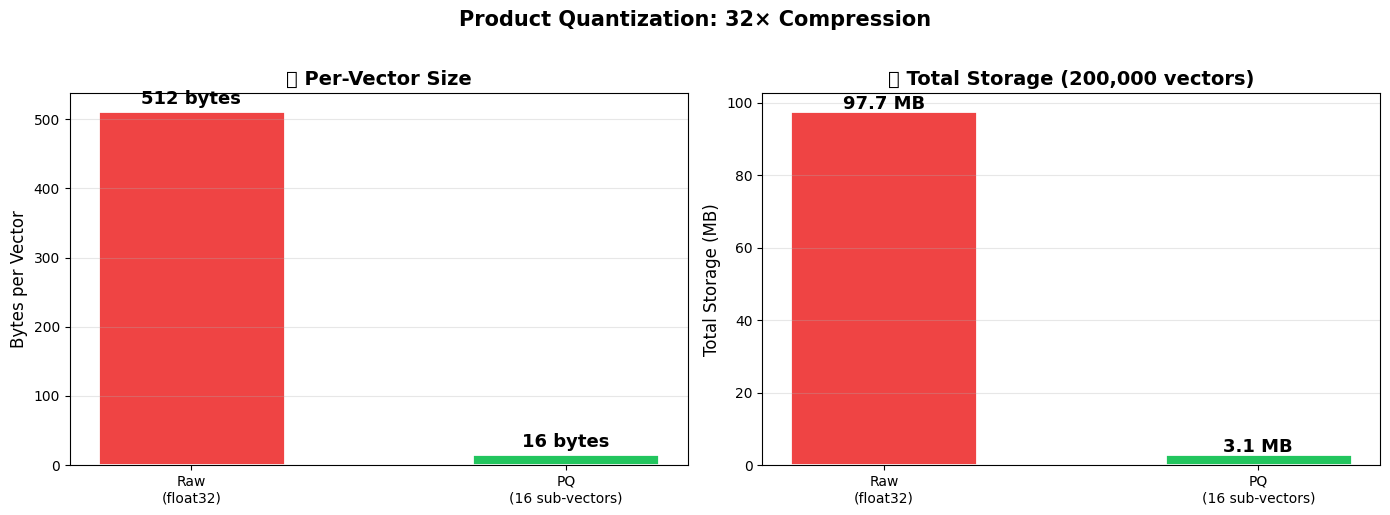


🎉 PQ reduces storage from 97.7 MB to 3.1 MB — that's 32× less!
   At 1 Billion vectors: 477 GB → 15 GB


In [14]:
# ── Storage visualization ─────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# ── Left: Per-vector comparison ──
methods = ['Raw\n(float32)', 'PQ\n(16 sub-vectors)']
sizes   = [raw_bytes, pq_bytes]
colors  = ['#ef4444', '#22c55e']

bars = ax1.bar(methods, sizes, color=colors, edgecolor='white', linewidth=2, width=0.5)
for bar, s in zip(bars, sizes):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
             f'{s} bytes', ha='center', fontsize=13, fontweight='bold')
ax1.set_ylabel('Bytes per Vector', fontsize=12)
ax1.set_title('📐 Per-Vector Size', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# ── Right: Total at our scale ──
total_sizes = [raw_total_mb, pq_total_mb]
bars = ax2.bar(methods, total_sizes, color=colors, edgecolor='white', linewidth=2, width=0.5)
for bar, s in zip(bars, total_sizes):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{s:.1f} MB', ha='center', fontsize=13, fontweight='bold')
ax2.set_ylabel('Total Storage (MB)', fontsize=12)
ax2.set_title(f'💾 Total Storage ({NUM_VECTORS:,} vectors)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.suptitle(f'Product Quantization: {compression:.0f}× Compression', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\n🎉 PQ reduces storage from {raw_total_mb:.1f} MB to {pq_total_mb:.1f} MB — that's {compression:.0f}× less!")
print(f"   At 1 Billion vectors: {raw_bytes * 1e9 / 1024**3:.0f} GB → {pq_bytes * 1e9 / 1024**3:.0f} GB")

---
## 🎛️ Effect of `num_sub_vectors` on Compression vs Recall

The `num_sub_vectors` parameter controls how aggressively we compress:

| Sub-vectors | Dims per sub-vec | Bytes per vector | Compression |
|-------------|-----------------|------------------|-------------|
| 8           | 16              | 8 bytes          | 64×         |
| 16          | 8               | 16 bytes         | 32×         |
| 32          | 4               | 32 bytes         | 16×         |
| 64          | 2               | 64 bytes         | 8×          |

More sub-vectors = less compression but better accuracy. Let's test this!

In [15]:
# ── Sub-vector Sensitivity Analysis ──────────────────────────
sub_vec_values = [8, 16, 32, 64]
NPROBES_FIXED = 20
sv_results = {}

print(f"🎛️  Testing num_sub_vectors (nprobes={NPROBES_FIXED})\n")
print(f"{'Sub-vecs':<12} {'Bytes/vec':<12} {'Compression':<14} {'Recall@'+str(TOP_K):<14} {'Latency (ms)':<12}")
print("─" * 80)

for nsv in sub_vec_values:
    # Build index with this setting
    tbl.create_index(
        metric="L2",
        num_partitions=NUM_PARTITIONS,
        num_sub_vectors=nsv,
        index_type="IVF_PQ",
    replace=True
    )
    
    # Benchmark
    result = benchmark_search(tbl, query_vectors, ground_truth, TOP_K, nprobes=NPROBES_FIXED)
    sv_results[nsv] = result
    
    bpv = nsv * 1   # bytes per vector after PQ
    comp = raw_bytes / bpv
    print(f"{nsv:<12} {bpv:<12} {comp:<14.0f}x {result['avg_recall']:<14.4f} {result['avg_time_ms']:<12.2f}")

print(f"\n💡 More sub-vectors = better recall but less compression.")
print(f"   16 sub-vectors is the sweet spot for 128D vectors.")

🎛️  Testing num_sub_vectors (nprobes=20)

Sub-vecs     Bytes/vec    Compression    Recall@10      Latency (ms)
────────────────────────────────────────────────────────────────────────────────
8            8            64            x 0.0840         1.14        
16           16           32            x 0.1600         1.29        
32           32           16            x 0.3980         1.44        
64           64           8             x 0.7340         2.05        

💡 More sub-vectors = better recall but less compression.
   16 sub-vectors is the sweet spot for 128D vectors.


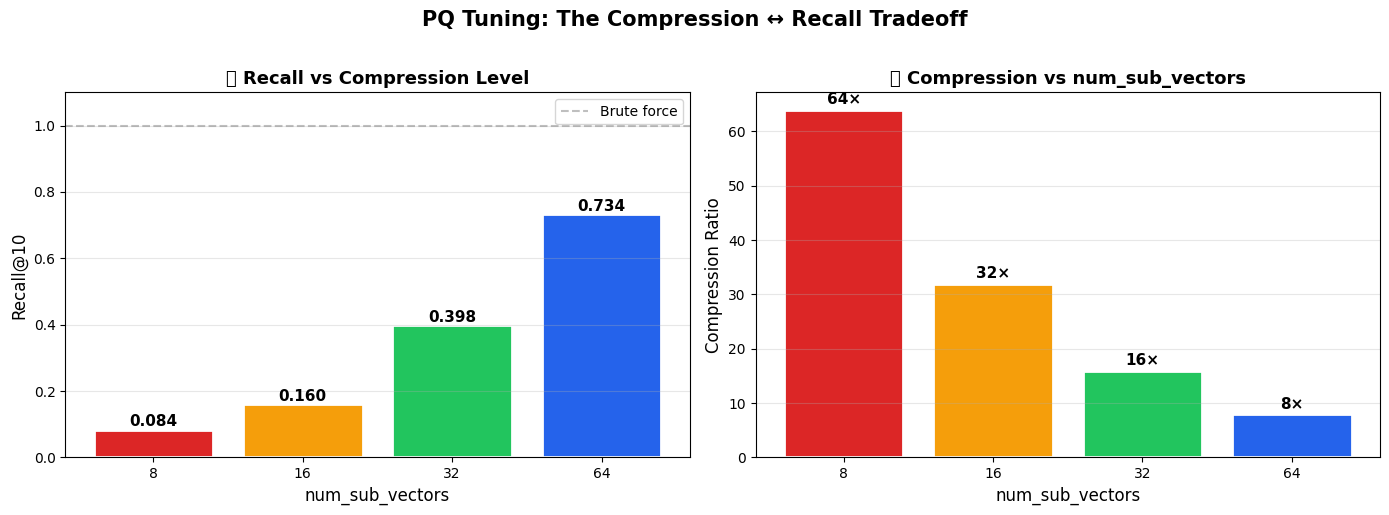


📌 KEY TAKEAWAYS FROM THIS NOTEBOOK:
   1. PQ compresses vectors by splitting into sub-vectors and encoding with codebook IDs
   2. With 16 sub-vectors, we get 32× compression (512 → 16 bytes per vector)
   3. Compression causes some recall loss — distances are approximated
   4. Refine factor recovers recall by re-ranking with original vectors
   5. num_sub_vectors controls the compression ↔ accuracy tradeoff

👉 Next: Notebook 3 explores Scalar Quantization — a simpler compression approach!


In [16]:
# ── Visualize sub-vector tradeoff ─────────────────────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

sv_labels      = [str(s) for s in sub_vec_values]
sv_recalls     = [sv_results[s]['avg_recall'] for s in sub_vec_values]
sv_compressions = [raw_bytes / (s * 1) for s in sub_vec_values]

# Recall vs sub-vectors
ax1.bar(sv_labels, sv_recalls, color=['#dc2626', '#f59e0b', '#22c55e', '#2563eb'],
        edgecolor='white', linewidth=2)
ax1.axhline(y=bf_results['avg_recall'], color='gray', linestyle='--', alpha=0.5, label='Brute force')
for i, (label, r) in enumerate(zip(sv_labels, sv_recalls)):
    ax1.text(i, r + 0.01, f'{r:.3f}', ha='center', fontsize=11, fontweight='bold')
ax1.set_xlabel('num_sub_vectors', fontsize=12)
ax1.set_ylabel(f'Recall@{TOP_K}', fontsize=12)
ax1.set_title('🎯 Recall vs Compression Level', fontsize=13, fontweight='bold')
ax1.set_ylim(0, 1.1)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Compression ratio
ax2.bar(sv_labels, sv_compressions, color=['#dc2626', '#f59e0b', '#22c55e', '#2563eb'],
        edgecolor='white', linewidth=2)
for i, (label, c) in enumerate(zip(sv_labels, sv_compressions)):
    ax2.text(i, c + 1, f'{c:.0f}×', ha='center', fontsize=11, fontweight='bold')
ax2.set_xlabel('num_sub_vectors', fontsize=12)
ax2.set_ylabel('Compression Ratio', fontsize=12)
ax2.set_title('📦 Compression vs num_sub_vectors', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.suptitle('PQ Tuning: The Compression ↔ Recall Tradeoff', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n📌 KEY TAKEAWAYS FROM THIS NOTEBOOK:")
print("   1. PQ compresses vectors by splitting into sub-vectors and encoding with codebook IDs")
print(f"   2. With 16 sub-vectors, we get {int(compression)}× compression (512 → 16 bytes per vector)")
print("   3. Compression causes some recall loss — distances are approximated")
print("   4. Refine factor recovers recall by re-ranking with original vectors")
print("   5. num_sub_vectors controls the compression ↔ accuracy tradeoff")
print("\n👉 Next: Notebook 3 explores Scalar Quantization — a simpler compression approach!")